In [12]:
import sys
sys.path.append("..")

from newutils.pickleloader import load_pickle, dump_pickle
import newutils.fdt as fdt
import newutils.mhue as mhue
import newutils.homogeneity as homogeneity
import newutils.stability as stability
import newutils.match_groundtruth as match_groundtruth
import newutils.region as region
import newutils.bound as bound

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import distance_transform_cdt
from vmdpy import VMD

def crop_image(image):
    x1 = np.min(np.where(image>1)[0])
    x2 = np.max(np.where(image>1)[0])
    y1 = np.min(np.where(image>1)[1])
    y2 = np.max(np.where(image>1)[1])
#     print((x1,x2),(y1,y2))
    return image[x1:x2, y1:y2]

In [58]:
importlib.reload(bound)

<module 'newutils.bound' from '../newutils/bound.py'>

In [2]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [60]:
def run(img_idx):
    # Masking parameter
    beta = 10
    
    result = {}
    path = '../image/t1/'
    filenames = ['outImg' + str(idx) + '.bmp' for idx in img_idx]
    img_org_lst = [cv.imread(path+filename,0) for filename in filenames]
    truth_img_lst = [cv.imread('../image/groundtruth/('+str(idx)+').bmp',0) for idx in img_idx]
    
    # get best threshold
    best_t = match_groundtruth.get_best_t(img_org_lst,img_idx,truth_img_lst)
    
    # Mask and crop the image
    img_lst = []
    scharr_lst = []
    for img in img_org_lst:
        _,mask = cv.threshold(img,beta,255,0)
        mask = binary_fill_holes(mask)
        img = img*mask
        img = crop_image(img)
        img_denoise = cv.fastNlMeansDenoising(img,templateWindowSize=7,searchWindowSize=27)
        scharr = homogeneity.get_scharr(img_denoise)
        scharr = homogeneity.rank_normalize(scharr)
        scharr_lst.append(scharr)
        img_lst.append(img)
    
    # Calculate bdt
    print('======================================')
    print('Calculate BDT')
    print('======================================')
    img_bdts_o = []
    img_bdts_b = []
    for lst_idx,img in enumerate(img_lst):
        idx = img_idx[lst_idx]
        print('Index: {}, Calculating BDT...'.format(str(idx)))
        image = img_lst[lst_idx]
        inten_min = np.min(image)
        inten_max = np.max(image)
        n_pixels = np.size(image)
        t1 = inten_min + 2
        t2 = inten_max - 2
        bdts_o = []
        bdts_b = []
        for t in range(t1, t2):
            # object
            _, src = cv.threshold(image, t, 255, cv.THRESH_BINARY)
            bdt_o = distance_transform_cdt(src,return_distances=True)
            bdts_o.append(bdt_o)
            # background
            src = 255-src
            bdt_b = distance_transform_cdt(src,return_distances=True)
            bdts_b.append(bdt_b)
        print('Index: {}, done.'.format(str(idx)))
        img_bdts_o.append(np.array(bdts_o))
        img_bdts_b.append(np.array(bdts_b))
    
    # original MHUE method
    print('======================================')
    print('Original MHUE method')
    print('======================================')
    uncertainty_lst = []
    mhue_lst = []
    mhue_t = []
    for idx,img in enumerate(img_lst):
        uncertainty = mhue.get_uncertainty(img)
        print('Index: {}, done.'.format(img_idx[idx]))
        
        uncertainty_lst.append(uncertainty)
        # homogeneity
        scharr = scharr_lst[idx]
        mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr)
        mhue_img = list(map(lambda x:np.sum(x), mhue_img))
        mhue_mint = np.argmin(mhue_img) + np.min(img) + 2
        print('Index: {}, MHUE threshold at: {}.'.format(img_idx[idx], mhue_mint))
        mhue_lst.append(mhue_img)
        mhue_t.append(mhue_mint)
        
    # Stability
    print('======================================')
    print('Calculate EMA-stability metric')
    print('======================================')
    stab_lst = []
    stabema_lst = []
    for idx,img in enumerate(img_lst):
        bdt_o = img_bdts_o[idx]
        pickle_name = "../pickle/stab"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            stab = load_pickle(pickle_name)
            print('Index: {}, pickle files found. Stability metric loaded.'.format(str(img_idx[idx])))
        else:
            stab = stability.get_stability(img,bdt_o)
            # cache the stab metric
            dump_pickle(pickle_name,stab)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        stab_lst.append(stab)
        stab = stability.pix_scale(stab,bdt_o)
#         stab = stability.get_emastab(stab,10)
#         stabema_lst.append(stab)
    

    # Weighted uncertainty
    print('======================================')
    print('Calculate Weighted uncertainty')
    print('======================================')
    uncertaintyw_lst = []
    uncertaintyw_t = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                            bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=21,sigma=0.7)
        uncertaintyw_lst.append(uncertaintyw)
        print('Index: {}, done.'.format(img_idx[idx]))
    
    # Weighted MHUE
    print('======================================')
    print('Calculate Weighted MHUE')
    print('======================================')
    mhuew_lst = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = uncertaintyw_lst[idx]
        scharr = scharr_lst[idx]
        mhuew_i = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr)
        mhuew_lst.append(mhuew_i)
        print('Index: {}, done.'.format(img_idx[idx]))

    # Bounding Grad
    print('======================================')
    print('Calculate Bounded Gradient Map')
    print('======================================')
    scharr_b_lst = []
    for idx,img in enumerate(img_lst):
        scharr = scharr_lst[idx]
        bdts_o = img_bdts_o[idx]
        scharr_b = bound.get_scharr_bounding(img, scharr, bdts_o, 60)
        scharr_b_lst.append(scharr_b)
        print('Index: {}, done.'.format(img_idx[idx]))
    
        
    # New region methods
    print('======================================')
    print('Calculate Bounded Weighted Region score')
    print('======================================')
    regions = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = uncertaintyw_lst[idx]
        scharr = scharr_b_lst[idx]
        region_i = region.get_score(img,uncertainty=uncertaintyw,homogeneity=scharr,kernel_size=5,bounding=True)
        print('Index: {}, done.'.format(img_idx[idx]))
        regions.append(region_i)
        
        r_sum = list(map(lambda x:np.sum(x),region_i))

        r_recon_all, _, _ = VMD(r_sum, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
        r_recon = list(r_recon_all[0,:])
        for mode in range(1,r_recon_all.shape[0]):
            if np.var(r_recon_all[mode,:])/np.sum(np.var(r_recon_all,axis=1)) > 0.01:
                r_recon += r_recon_all[mode,:]
        
        best_region_t = np.argmax(r_recon) + np.min(img) + 2
        print('Index: {}, Region score threshold at: {}.'.format(img_idx[idx], best_region_t))
    
    # return dict
    result['bdts_o'] = img_bdts_o
    result['bdts_b'] = img_bdts_b
    result['mhue'] = mhue_lst
    result['stab'] = stab_lst
    result['uncertaintyw'] = uncertaintyw_lst
    result['uncertainty'] = uncertainty_lst
    result['mhuew'] = mhuew_lst
    result['img'] = img_lst
    result['truth'] = truth_img_lst
    result['bestt'] = best_t
    result['regions'] = regions
    
    return result

In [61]:
test_lst = [5,14,21,30,47,60,74,83,95,106,112,125]
# test_lst = [74]
res = run(test_lst)

Finding best threshold by error rate
Index: 5, done. Best threshold at: 54
Index: 14, done. Best threshold at: 58
Index: 21, done. Best threshold at: 57
Index: 30, done. Best threshold at: 59
Index: 47, done. Best threshold at: 62
Index: 60, done. Best threshold at: 62
Index: 74, done. Best threshold at: 64
Index: 83, done. Best threshold at: 64
Index: 95, done. Best threshold at: 62
Index: 106, done. Best threshold at: 68
Index: 112, done. Best threshold at: 67
Index: 125, done. Best threshold at: 68
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Calculate BDT
Index: 5, Calculating BDT...
Index: 5, done.
Index: 14, Calculating BDT...
Index: 1

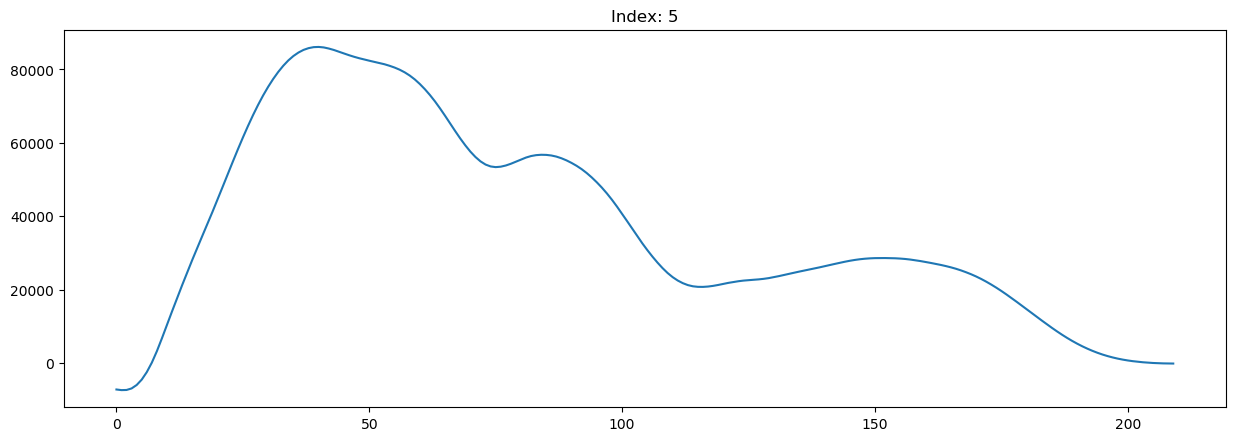

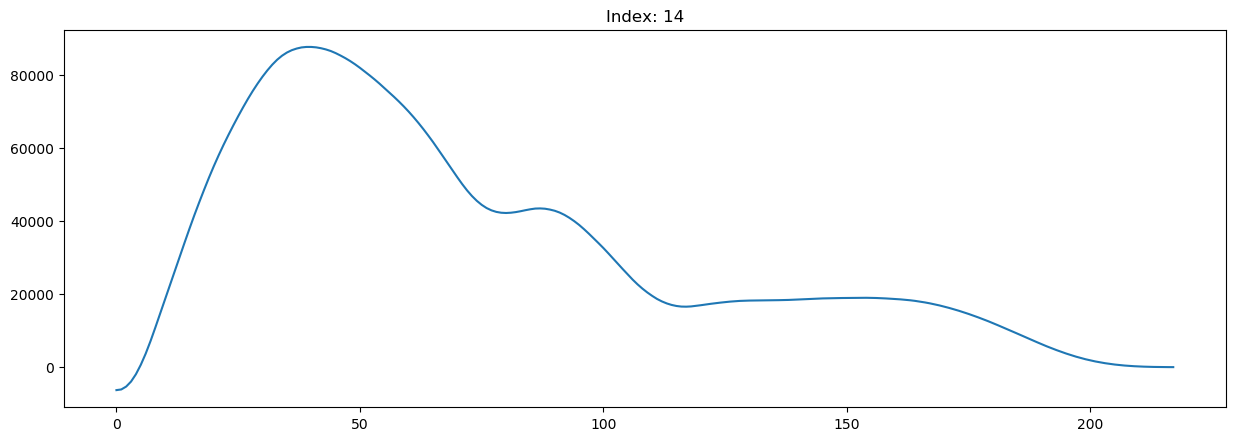

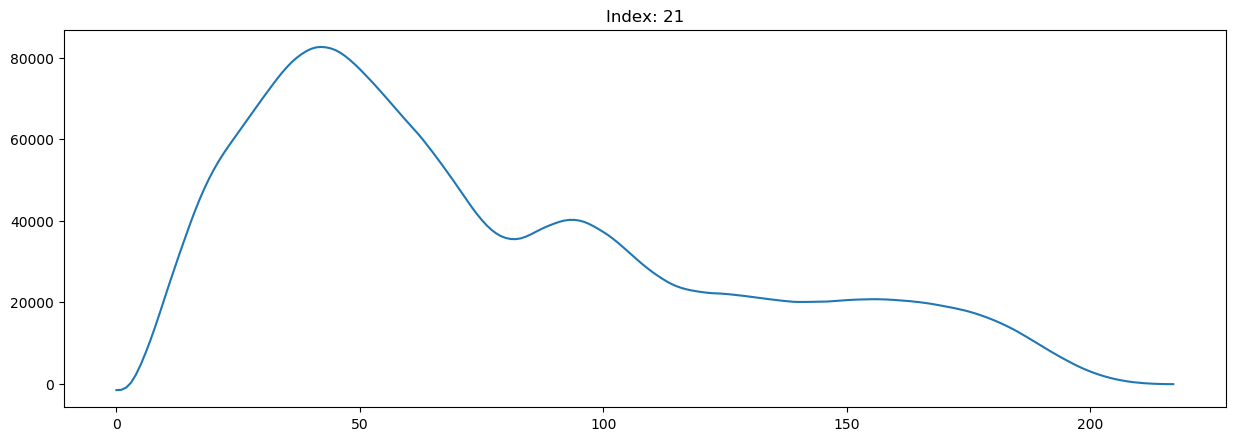

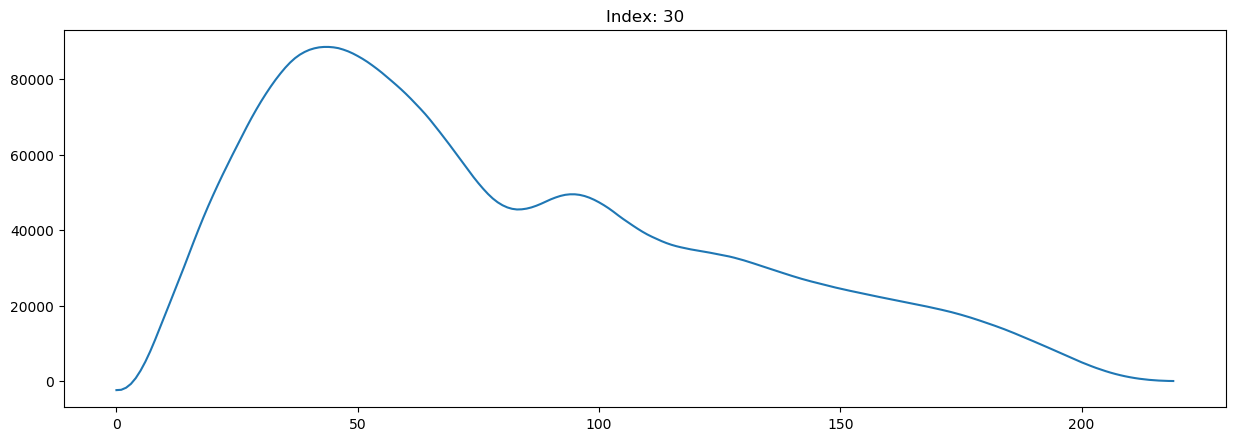

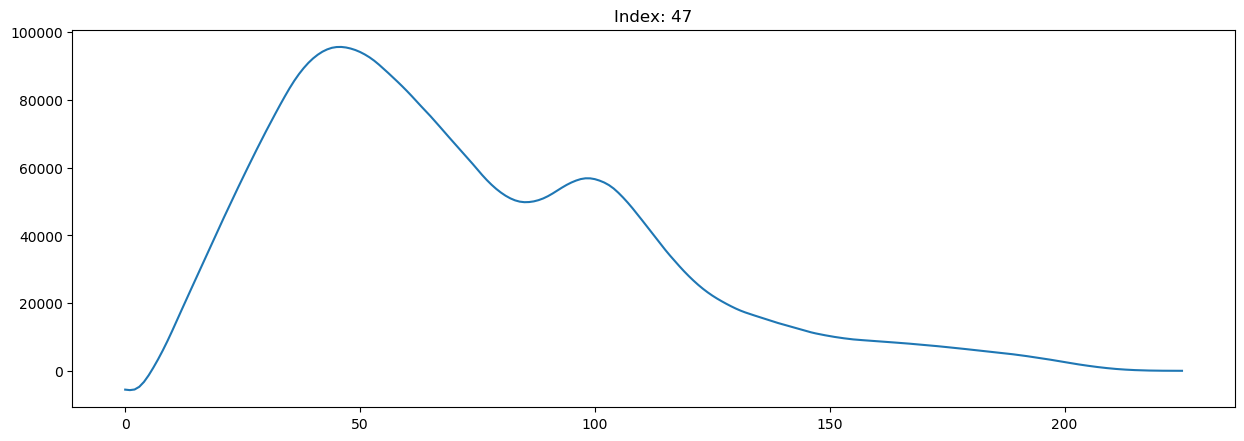

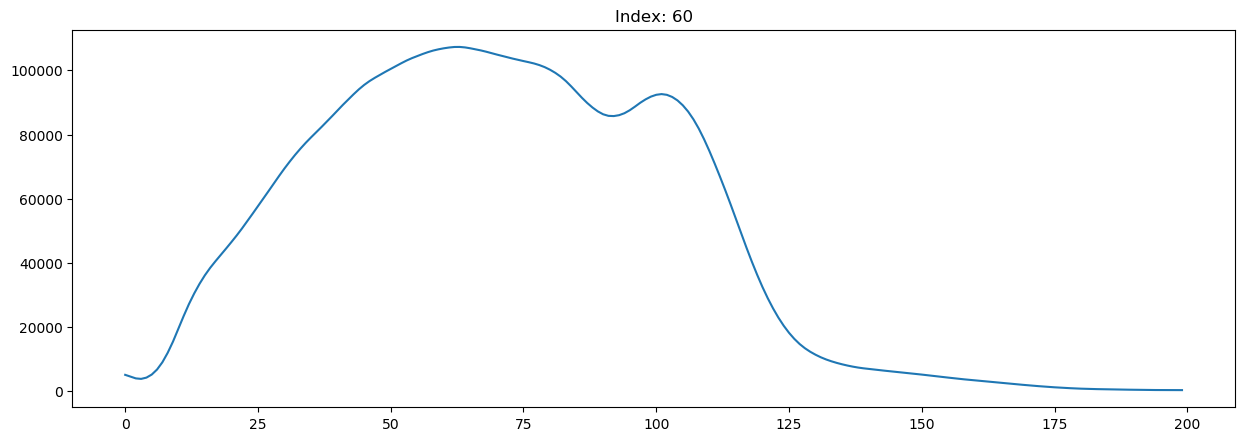

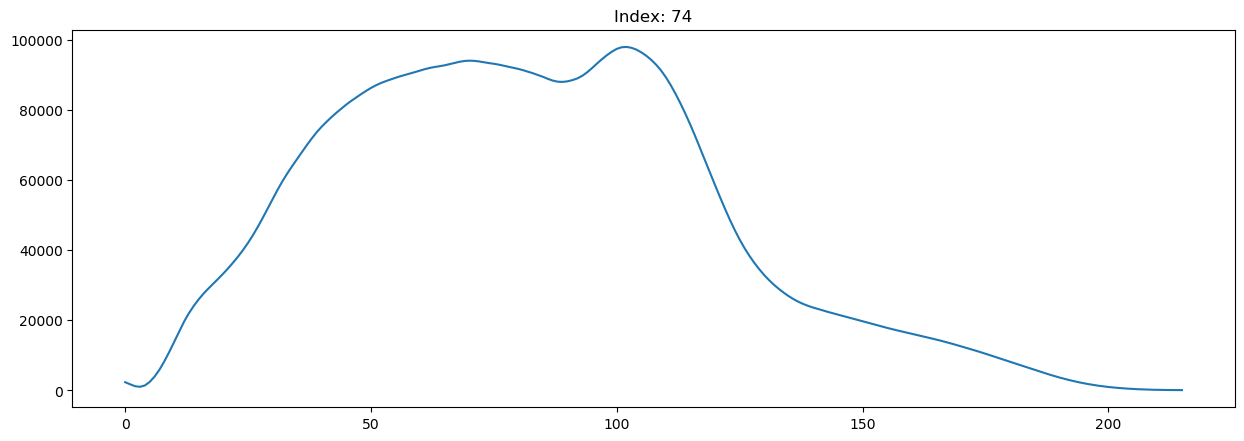

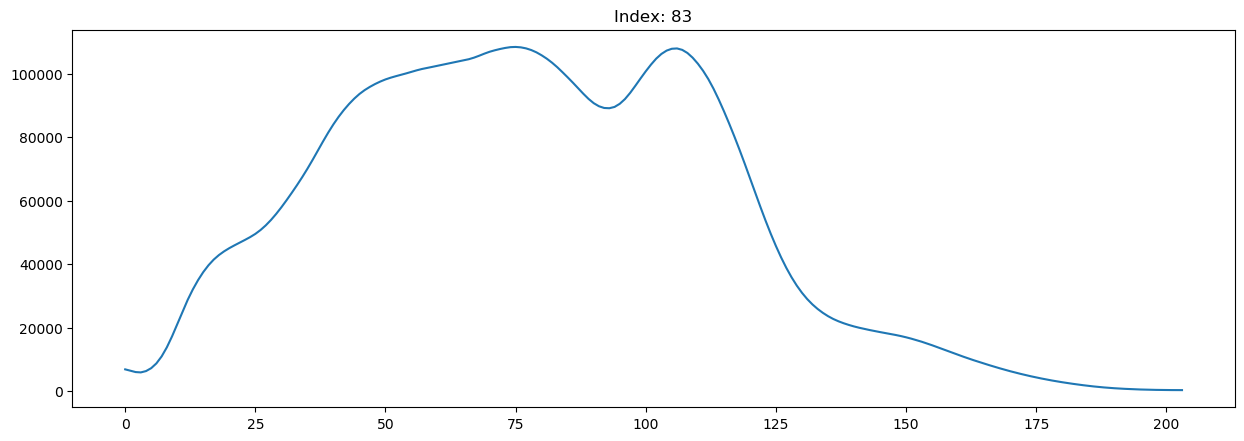

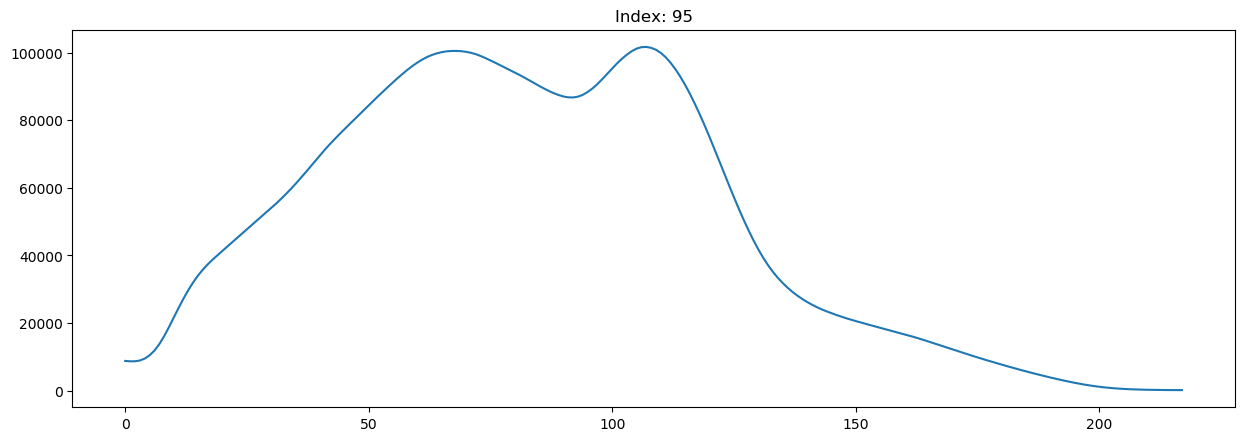

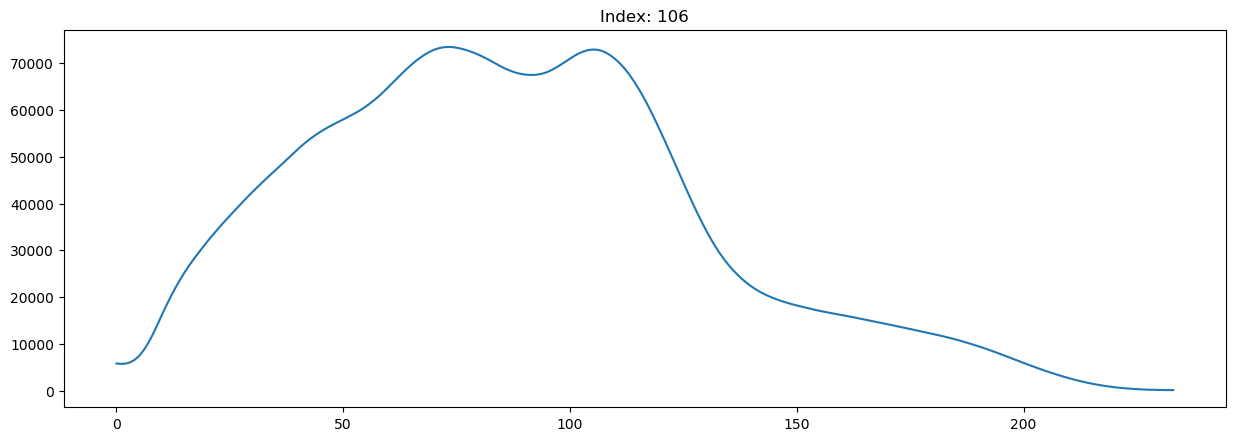

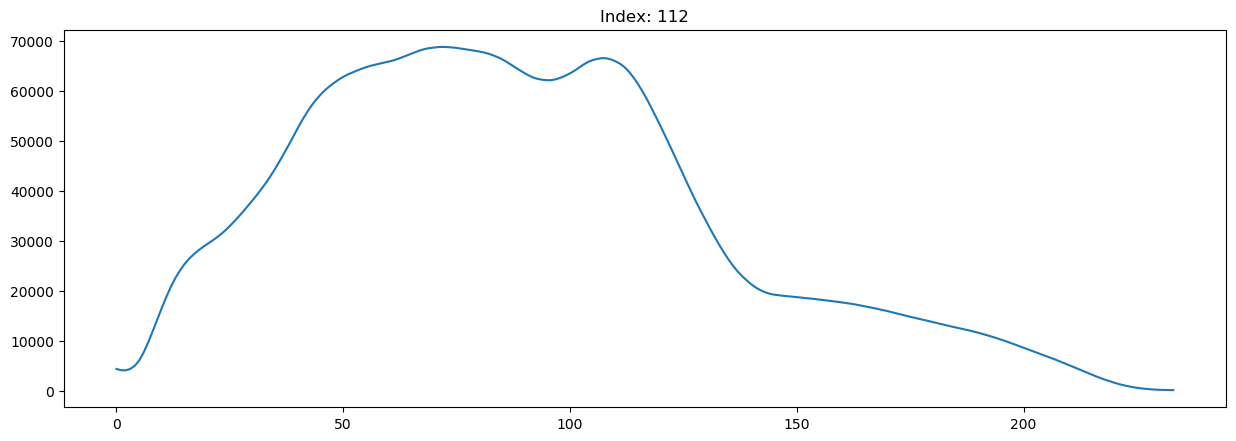

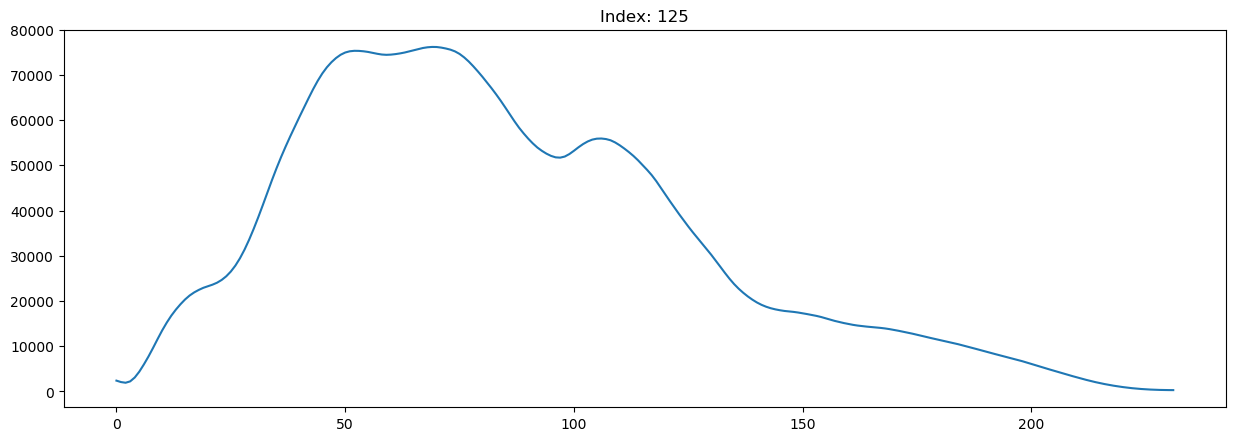

In [66]:
_region = res['regions']
_t = []
for i in range(len(test_lst)):
    plt.figure(figsize=(15,5))
    region_i = _region[i]
    r_sum = list(map(lambda x:np.sum(x),region_i))

    r_recon_all, _, _ = VMD(r_sum, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
    r_recon = list(r_recon_all[0,:])
    for mode in range(1,r_recon_all.shape[0]):
        if np.var(r_recon_all[mode,:])/np.sum(np.var(r_recon_all,axis=1)) > 0.01:
            r_recon += r_recon_all[mode,:]
    _t.append(argrelmax(r_recon)[0][0])
    plt.plot(r_recon)
    plt.title('Index: {}'.format(test_lst[i]))

In [67]:
_t

[40, 40, 42, 44, 46, 63, 70, 75, 68, 73, 72, 52]

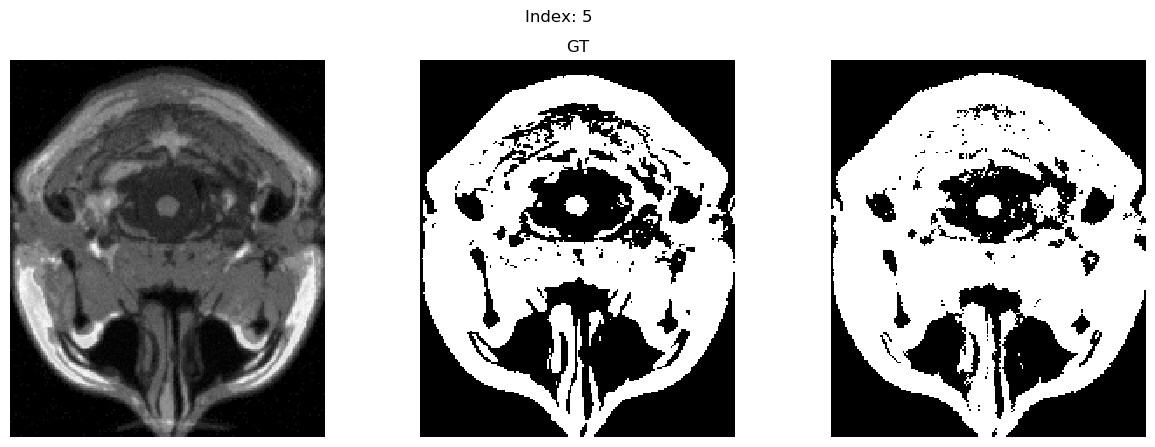

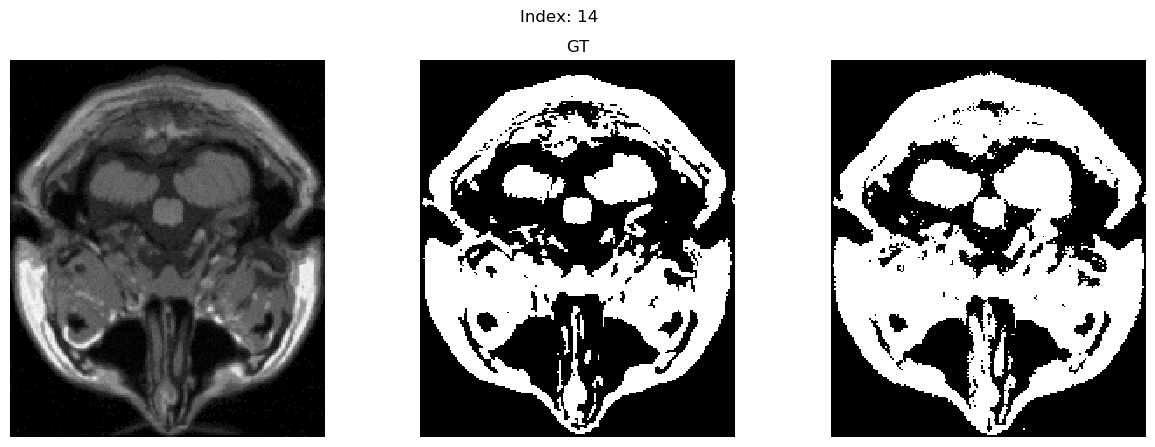

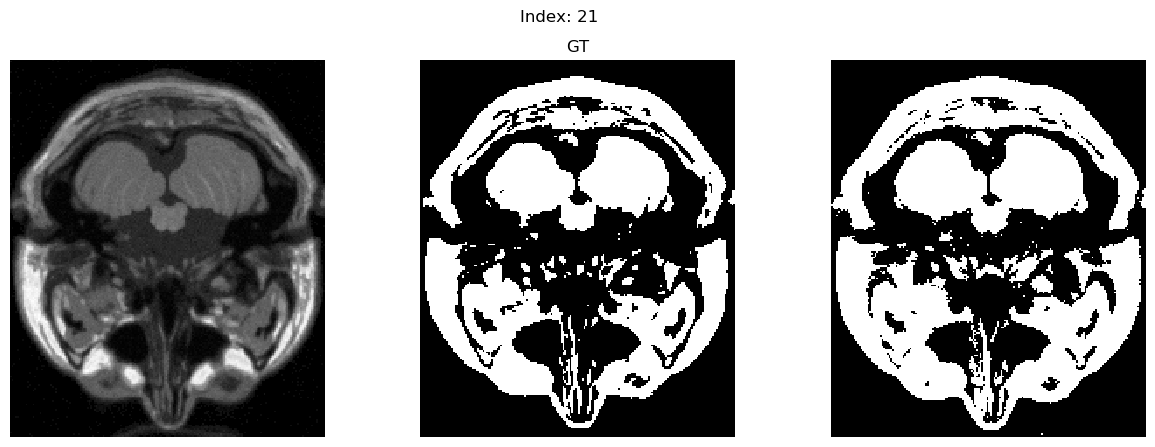

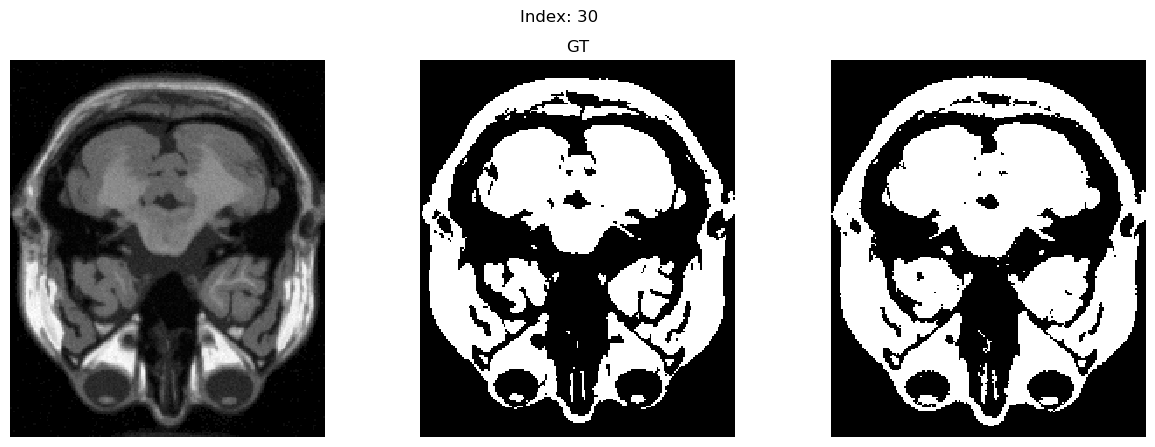

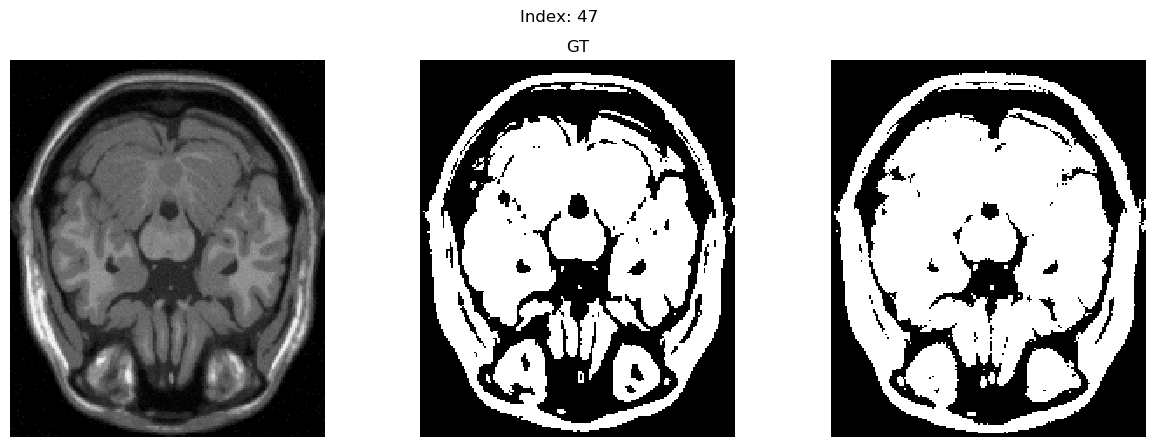

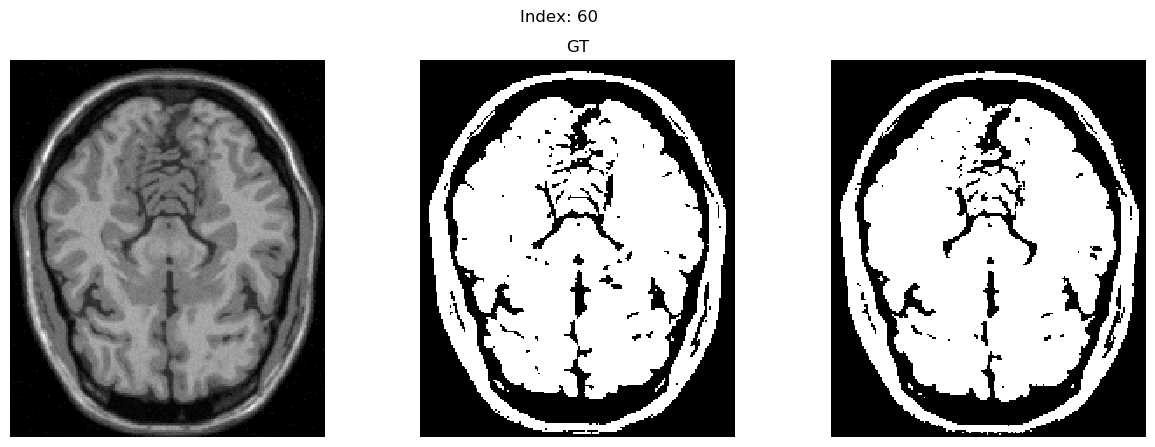

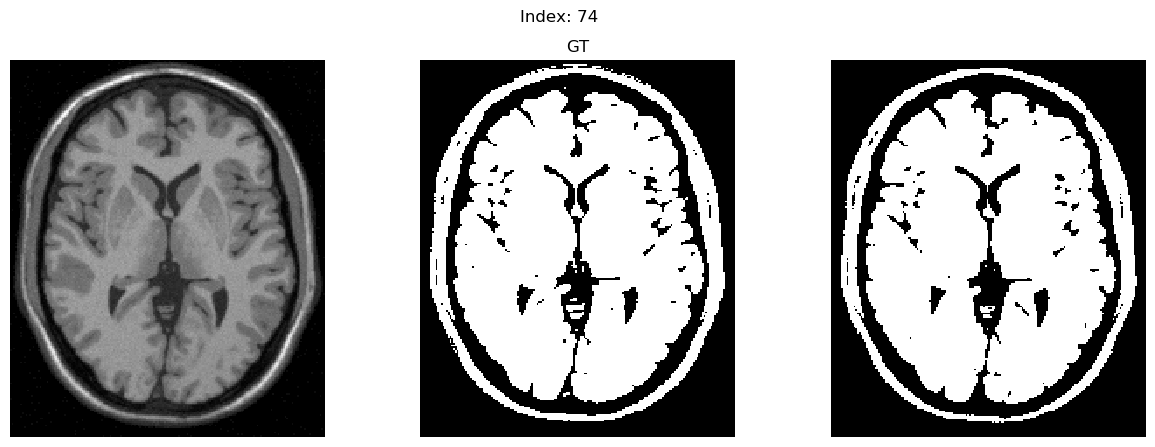

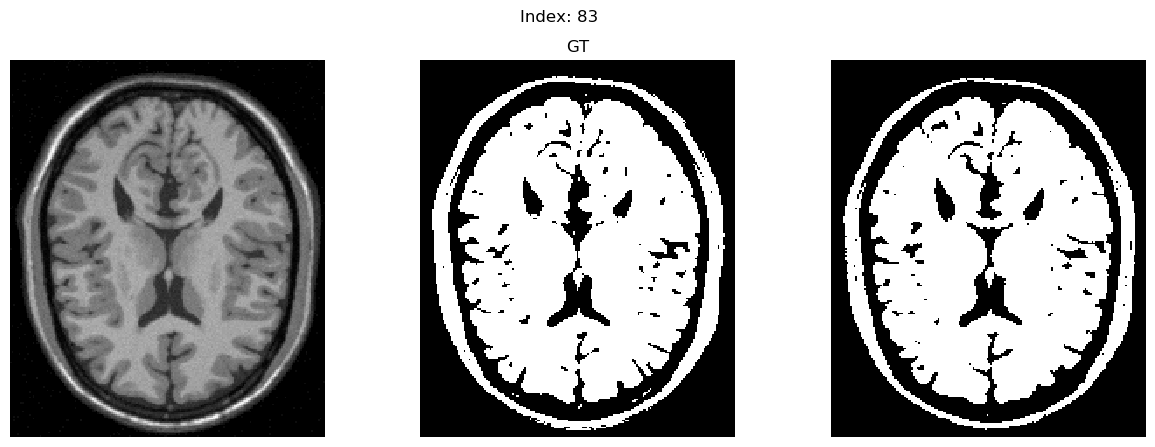

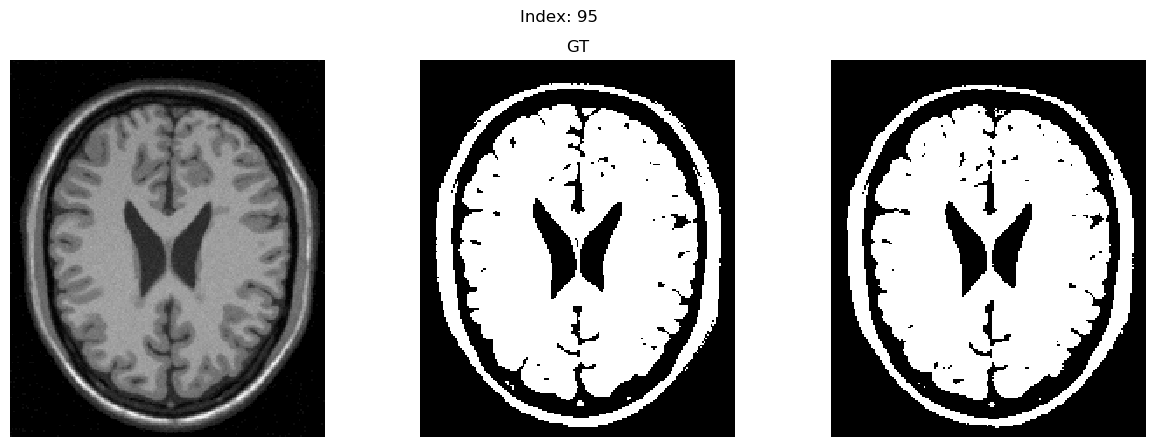

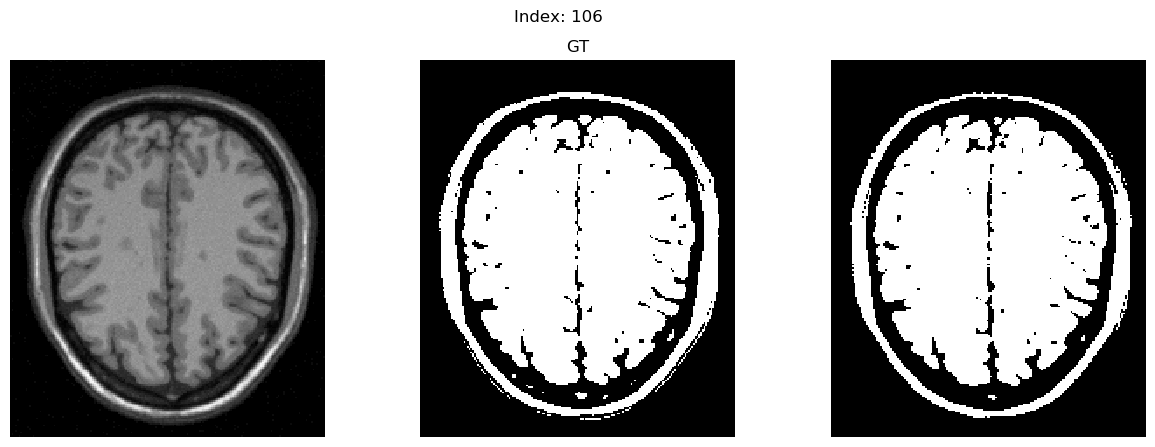

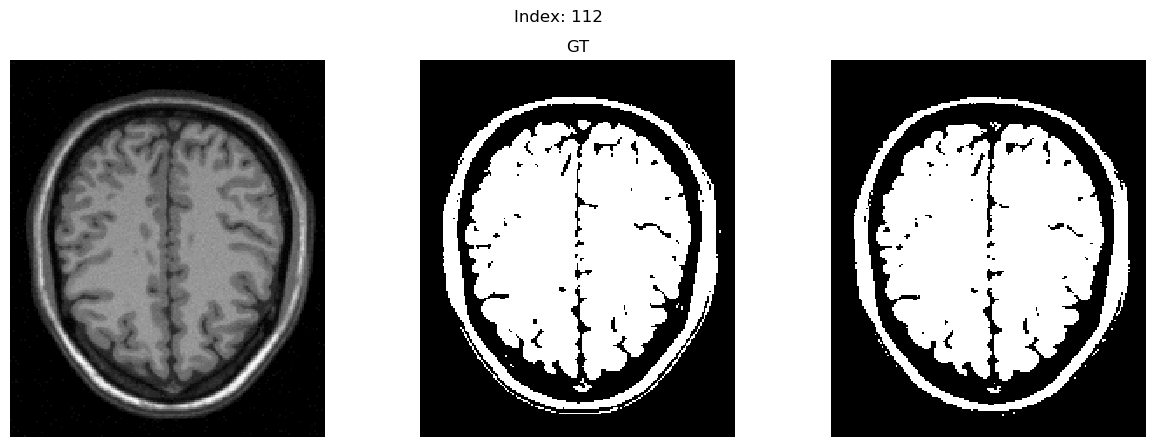

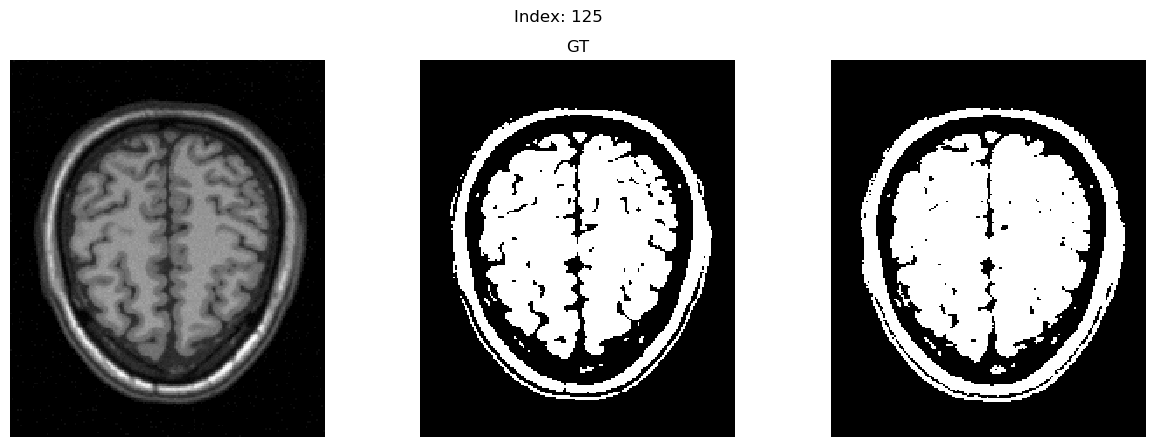

In [69]:
_img = res['img']
_truth = res['truth']
for i in range(len(test_lst)):
    plt.figure(figsize=(15,5))
    plt.suptitle('Index: {}'.format(test_lst[i]))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(_img[i])
    plt.subplot(132)
    plt.axis('off')
    plt.title('GT')
    plt.imshow(_truth[i])
    plt.subplot(133)
    plt.axis('off')
    _,tmp = cv.threshold(_img[i], _t[i]+np.min(_img[i])+2, 255, 0)
    plt.imshow(tmp)